## ....................Intel Product Sentiment Analysis........................

### Data Loading and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import joblib

In [2]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer  # for stemming (or import nltk.stem.WordNetLemmatizer for lemmatization)
from sklearn.feature_extraction.text import TfidfVectorizer

### Exploratory Data Analysis (EDA)

In [5]:
review_df = pd.read_csv("C:/Users/deepe/OneDrive/Desktop/NLP_Intel_training/Intel_product_reviews_cleaned.csv")
review_df.head()

,Product Name,Review Text,Review Rating,Country,date,year,Tokens
0,Intel Core i5-14600K Processor,good processor gives able play games office wo...,5,Spain,05-16-2024,2024,"['good', 'processor', 'gives', 'able', 'play',..."
1,Intel Core i5-14600K Processor,criticized almost 13600k price also almost thi...,4,Japan,03-13-2024,2024,"['criticized', 'almost', '13600k', 'price', 'a..."
2,Intel Core i5-14600K Processor,tried limiting power 160w using cooler masters...,3,Japan,03-20-2024,2024,"['tried', 'limiting', 'power', '160w', 'using'..."
3,Intel Core i5-14600K Processor,product safe good condition really appreciate ...,5,Mexico,03-23-2024,2024,"['product', 'safe', 'good', 'condition', 'real..."
4,Intel Core i5-14600K Processor,processor great arrived sealed good condition ...,4,the United States,05-05-2024,2024,"['processor', 'great', 'arrived', 'sealed', 'g..."


In [6]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3951 entries, 0 to 3950
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Product Name   3951 non-null   object
 1   Review Text    3929 non-null   object
 2   Review Rating  3951 non-null   int64 
 3   Country        3951 non-null   object
 4   date           3951 non-null   object
 5   year           3951 non-null   int64 
 6   Tokens         3951 non-null   object
dtypes: int64(2), object(5)
memory usage: 216.2+ KB


In [7]:
review_df.describe()

,Review Rating,year
count,3951.000000,3951.000000
mean,4.591243,2023.193622
std,0.972125,0.686374
min,1.000000,2022.000000
25%,5.000000,2023.000000
50%,5.000000,2023.000000
75%,5.000000,2024.000000
max,5.000000,2024.000000


In [8]:
# Check for missing values
review_df.isnull().sum()

Product Name      0
Review Text      22
Review Rating     0
Country           0
date              0
year              0
Tokens            0
dtype: int64

##### Number of Processors reviewed in each country

In [25]:
# Clean the Country column if necessary (e.g., standardize country names)
review_df['Country'] = review_df['Country'].str.strip()

# Group by Country and count the number of processors sold
country_counts = review_df['Country'].value_counts()

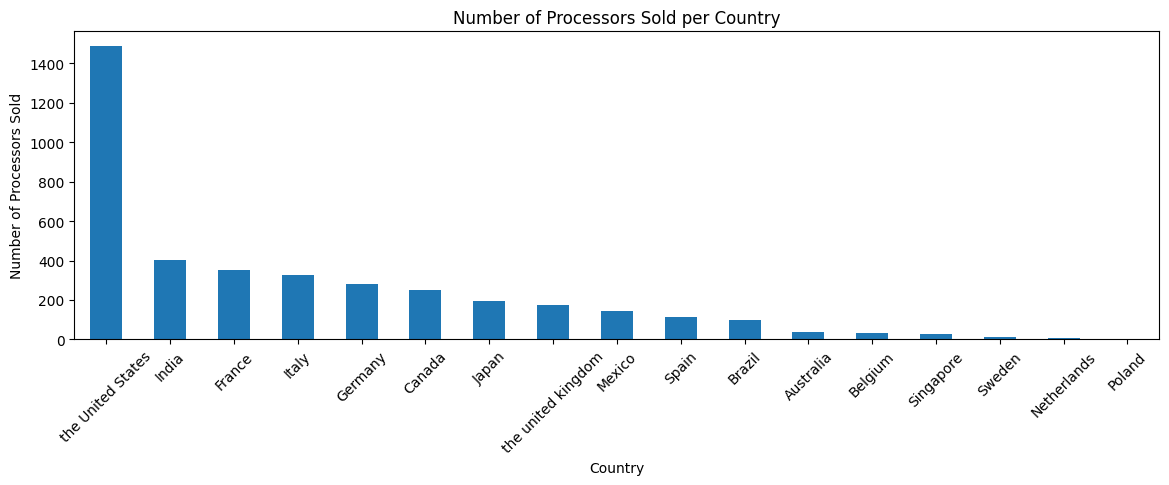

In [26]:
# Plotting the results
plt.figure(figsize=(14, 4))
country_counts.plot(kind='bar')
plt.title('Number of Processors Sold per Country')
plt.xlabel('Country')
plt.ylabel('Number of Processors Sold')
plt.xticks(rotation=45)
plt.show()

Invalid dates found:
Empty DataFrame
Columns: [Product Name, Review Text, Review Rating, Country, date, year, Tokens]
Index: []


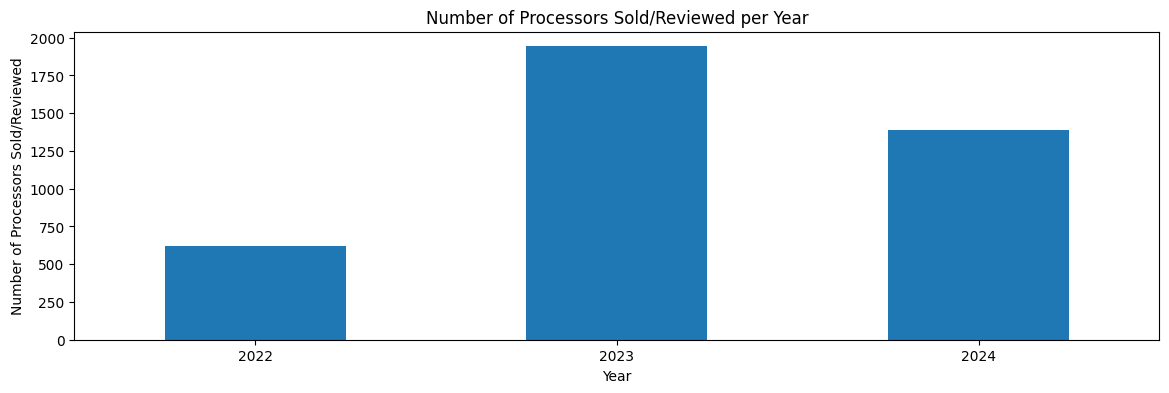

In [27]:
# Attempt to convert the date column to datetime format
# Allow pandas to infer the format
review_df['date'] = pd.to_datetime(review_df['date'], errors='coerce')

# Check for any rows where the date conversion failed
invalid_dates = review_df[review_df['date'].isna()]
print("Invalid dates found:")
print(invalid_dates)

# If any invalid dates are found, they need to be corrected manually or excluded
# For the purpose of this example, we will drop rows with invalid dates
review_df = review_df.dropna(subset=['date'])

# Extract the year from the date column
review_df['year'] = review_df['date'].dt.year

# Group by year and count the number of processors sold/reviewed
yearly_counts = review_df['year'].value_counts().sort_index()

# Plotting the results
plt.figure(figsize=(14, 4))
yearly_counts.plot(kind='bar')
plt.title('Number of Processors Sold/Reviewed per Year')
plt.xlabel('Year')
plt.ylabel('Number of Processors Sold/Reviewed')
plt.xticks(rotation=0)
plt.show()

In [28]:
# Convert the date column to datetime format
review_df['date'] = pd.to_datetime(review_df['date'], format='%m-%d-%Y')

# Filter rows where the year is 2020 or 2021
years_to_replace = review_df['date'].dt.year.isin([2020, 2021, 2002])

# Generate random years (2023 or 2024) for the filtered rows
random_years = np.random.choice([2023, 2024], size=years_to_replace.sum())

# Update the date column with the randomly generated years
review_df.loc[years_to_replace, 'date'] = review_df.loc[years_to_replace, 'date'].apply(
    lambda x: x.replace(year=random_years[0]) if x.year in [2020, 2021,2002] else x)

# Convert the date column back to the desired format (mm/dd/yy)
review_df['date'] = review_df['date'].dt.strftime('%m-%d-%Y')

# Display the updated DataFrame
print(review_df)

                         Product Name  \
0      Intel Core i5-14600K Processor   
1      Intel Core i5-14600K Processor   
2      Intel Core i5-14600K Processor   
3      Intel Core i5-14600K Processor   
4      Intel Core i5-14600K Processor   
...                               ...   
3946  Intel Core i9-12950HX Processor   
3947  Intel Core i9-12950HX Processor   
3948  Intel Core i9-12950HX Processor   
3949  Intel Core i9-12950HX Processor   
3950  Intel Core i9-12950HX Processor   

                                            Review Text  Review Rating  \
0     good processor gives able play games office wo...              5   
1     criticized almost 13600k price also almost thi...              4   
2     tried limiting power 160w using cooler masters...              3   
3     product safe good condition really appreciate ...              5   
4     processor great arrived sealed good condition ...              4   
...                                                 ...        

In [29]:
review_df.columns

Index(['Product Name', 'Review Text', 'Review Rating', 'Country', 'date',
       'year', 'Tokens'],
      dtype='object')

#### To see which country people liked the product most

In [30]:
unique_values = review_df['Review Rating'].unique()
unique_values

array([5, 4, 3, 2, 1], dtype=int64)

In [31]:
rating_count = review_df['Review Rating'].value_counts()
rating_count

Review Rating
5    3117
4     473
1     188
3     129
2      44
Name: count, dtype: int64

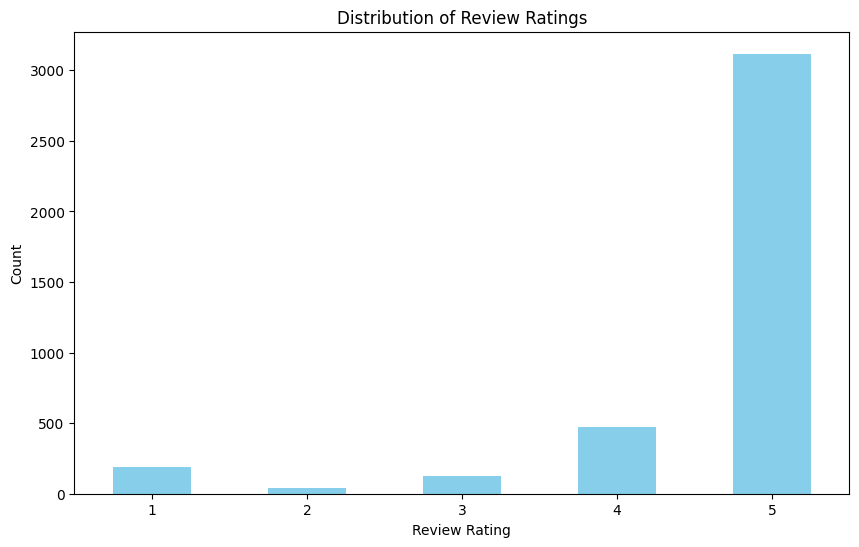

In [32]:
rating_count = review_df['Review Rating'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
rating_count.sort_index().plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Distribution of Review Ratings')
plt.xlabel('Review Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Let's see which country is having the highest average rating

In [33]:
# Group by country and calculate the average rating
average_rating_by_country = review_df.groupby('Country')['Review Rating'].mean()

# Find the country with the highest average rating
most_liked_country = average_rating_by_country.idxmax()
highest_average_rating = average_rating_by_country.max()

print(f"The country that liked the product the most is {most_liked_country} with an average rating of {highest_average_rating}.")

The country that liked the product the most is Netherlands with an average rating of 5.0.


### Let's see which country has the highest count of 5-star rating

In [34]:
# Filter the DataFrame to include only rows with the highest rating (5)
highest_ratings = review_df[review_df['Review Rating'] == 5]

# Count the occurrences of each country in the filtered DataFrame
country_counts = highest_ratings['Country'].value_counts()

# Find the country with the highest count of maximum ratings
most_liked_country = country_counts.idxmax()
highest_count = country_counts.max()

print(f"The country that liked the product the most is {most_liked_country} with {highest_count} 5-star ratings.")

The country that liked the product the most is the United States with 1256 5-star ratings.


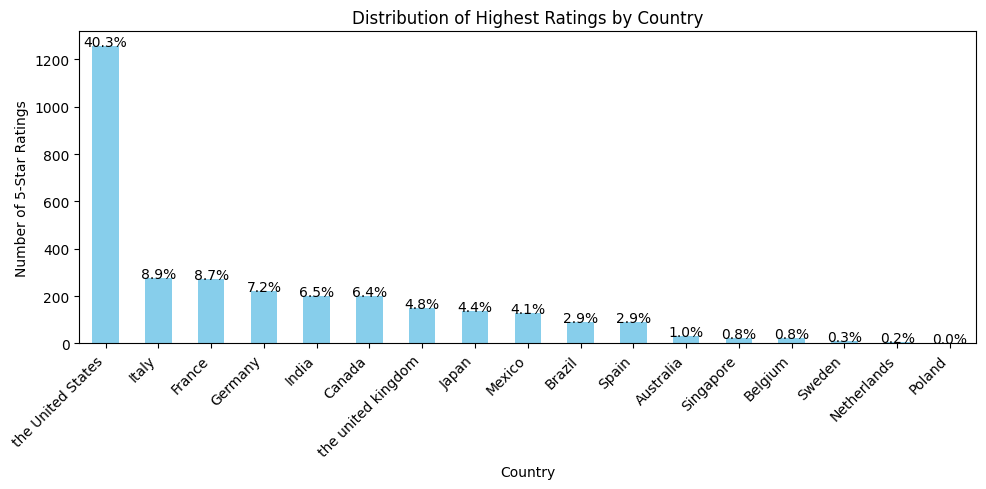

In [14]:
# Calculate percentage of each country's 5-star ratings
total_5_star_ratings = country_counts.sum()
percentages = (country_counts / total_5_star_ratings) * 100

# Plotting
plt.figure(figsize=(10, 5))
bars = country_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Highest Ratings by Country')
plt.xlabel('Country')
plt.ylabel('Number of 5-Star Ratings')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Annotate each bar with the percentage
for i, value in enumerate(country_counts):
    plt.text(i, value + 0.5, f'{percentages.iloc[i]:.1f}%', ha='center')

plt.tight_layout()
plt.show()



### Now the top 10 products with the highest average rating and the number of the ratings

In [35]:
# Group by 'Product Name' and calculate the number of reviews and the average rating
product_popularity = review_df.groupby('Product Name').agg({'Review Rating': ['count', 'mean']})
product_popularity.columns = ['Number of Reviews', 'Average Rating']

# Sort the products by the number of reviews
top_products = product_popularity.sort_values(by='Number of Reviews', ascending=False).head(10)

# Display the top products
print(top_products)
top_products.columns

                                 Number of Reviews  Average Rating
Product Name                                                      
Intel Core i5-1340P Processor                  100        4.290000
Intel Core i9-13905H Processor                 100        4.700000
Intel Core i7-12700K Processor                 100        4.770000
Intel Core i9-13900HK Processor                100        4.700000
Intel Core i9-13900K Processor                 100        4.700000
Intel Core i7-1370P Processor                  100        4.770000
Intel Core i7-13755HE Processor                100        4.770000
Intel Core i7-13705H Processor                 100        4.770000
Intel Core i3-13100H Processor                  99        4.656566
Intel Core i3-12100F Processor                  99        4.656566


Index(['Number of Reviews', 'Average Rating'], dtype='object')

C:\Users\deepe\AppData\Local\Temp\ipykernel_20444\3786731526.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_products.index, rotation=45, ha='right')


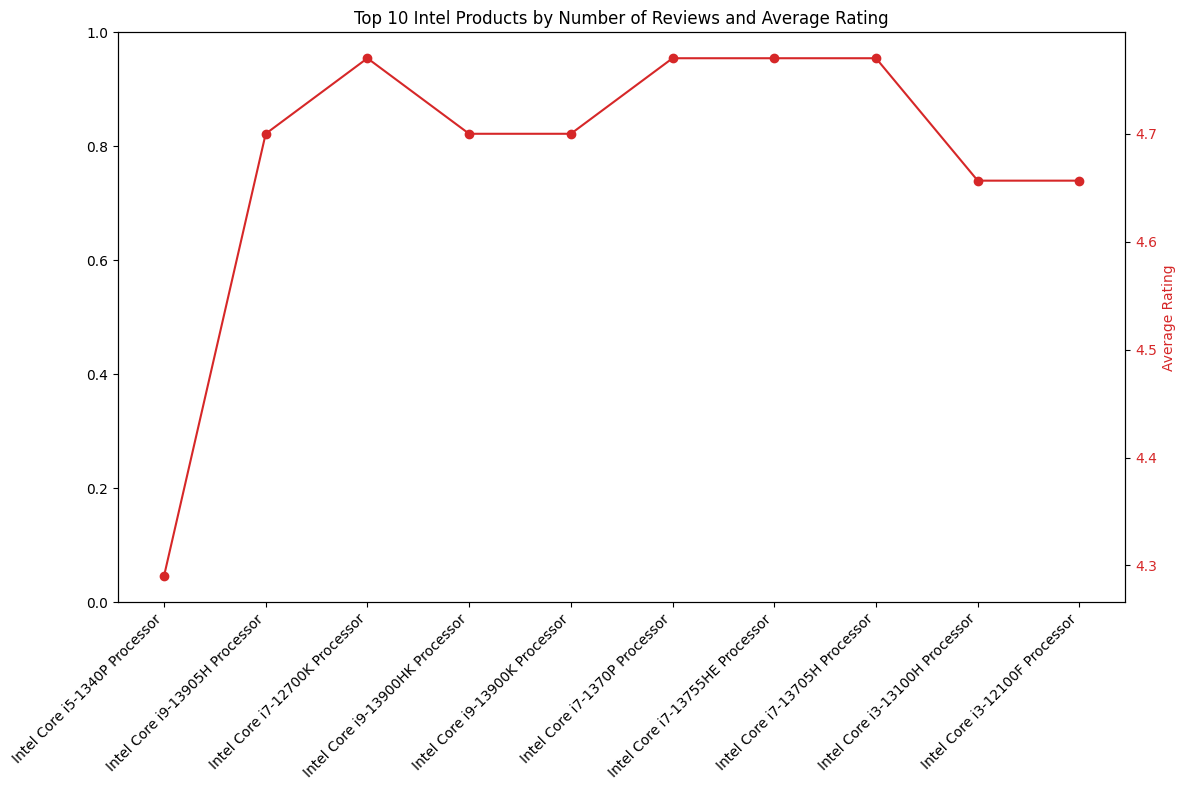

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming review_df is already loaded and processed
# Group by 'Product Name' and calculate the number of reviews and the average rating
product_popularity = review_df.groupby('Product Name').agg({'Review Rating': ['count', 'mean']})
product_popularity.columns = ['Number of Reviews', 'Average Rating']

# Sort the products by the number of reviews
top_products = product_popularity.sort_values(by='Number of Reviews', ascending=False).head(10)

# Plotting the graph
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.set_xticklabels(top_products.index, rotation=45, ha='right')

# Line plot for Average Rating
ax2 = ax1.twinx()  # instantiate a second y-axis that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Average Rating', color=color)
ax2.plot(top_products.index, top_products['Average Rating'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout adjustments
plt.title('Top 10 Intel Products by Number of Reviews and Average Rating')
fig.tight_layout()  # to ensure the right y-label is not slightly clipped

# Show the plot
plt.show()

#### Number of the reviews over the time

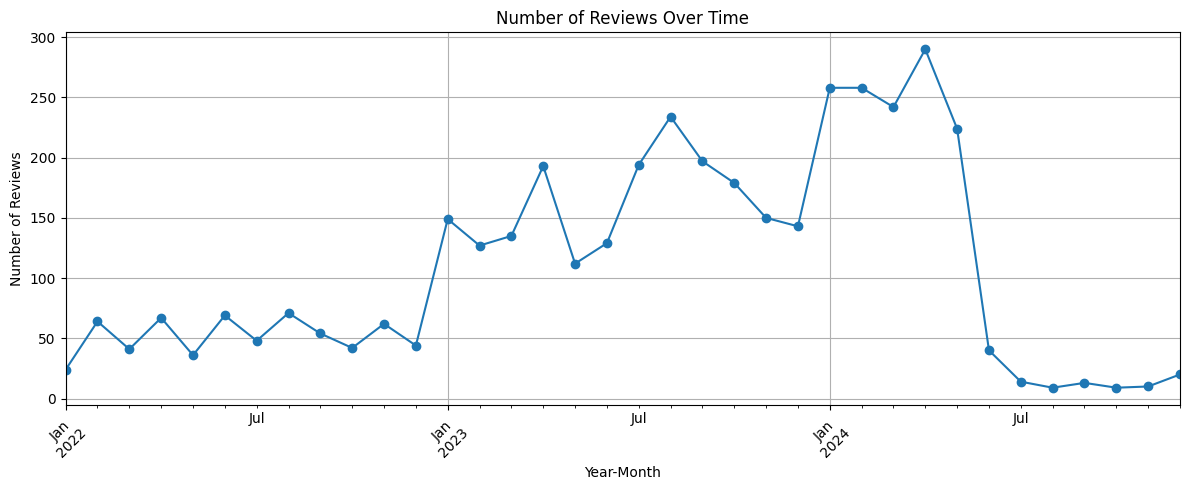

In [39]:
# Convert the 'date' column to datetime format
review_df['date'] = pd.to_datetime(review_df['date'], format='%m-%d-%Y')

# Extract year and month from the date column
review_df['YearMonth'] = review_df['date'].dt.to_period('M')

# Aggregate the data by YearMonth
time_series_data = review_df.groupby('YearMonth').size()

# Plot the time series data
plt.figure(figsize=(12, 5))
time_series_data.plot(kind='line', marker='o')
plt.title('Number of Reviews Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Finding the frequency of the coutries in the coulumn country

In [17]:
# Calculate the frequency of each country
country_counts = review_df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'frequency']

# Display the country frequency dataframe
print(country_counts)

               Country  frequency
0    the United States       1488
1                India        403
2               France        353
3                Italy        329
4              Germany        280
5               Canada        251
6                Japan        196
7   the united kingdom        173
8               Mexico        145
9                Spain        115
10              Brazil         98
11           Australia         39
12             Belgium         35
13           Singapore         26
14              Sweden         13
15         Netherlands          6
16              Poland          1


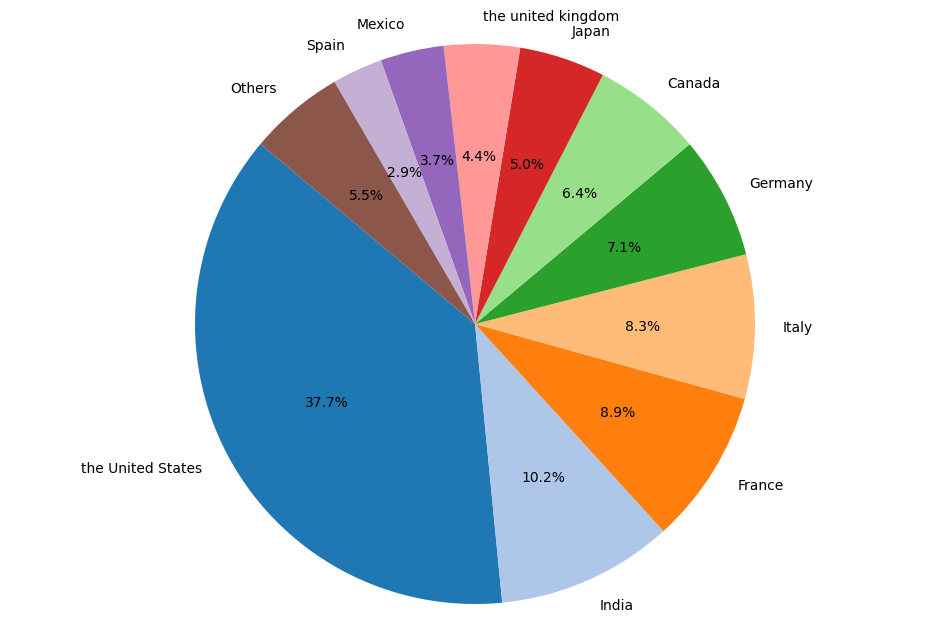

In [43]:
# Calculate the frequency of each country
country_counts = review_df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'frequency']

# Calculate total reviews for percentage calculation
total_reviews = country_counts['frequency'].sum()

# Calculate the percentage for each country
country_counts['percentage'] = (country_counts['frequency'] / total_reviews) * 100

# Separate out the "Others" category for countries with < 2.5% reviews
threshold = 2.5
large_countries = country_counts[country_counts['percentage'] >= threshold]
small_countries = country_counts[country_counts['percentage'] < threshold]

# Combine small countries into "Others"
others = pd.DataFrame([{'Country': 'Others', 'frequency': small_countries['frequency'].sum(), 'percentage': small_countries['percentage'].sum()}])
final_counts = pd.concat([large_countries, others], ignore_index=True)

# Plotting the pie chart
plt.figure(figsize=(12, 8))
plt.pie(final_counts['frequency'], labels=final_counts['Country'], autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)

# Display the plot
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [18]:
pip install pandas geopandas matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install textblob


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Sentiment Analysis

In [45]:
import pandas as pd
from textblob import TextBlob

# Define a function to calculate sentiment polarity
def get_sentiment(text):
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity
    else:
        return 0.0  # or return None if you prefer

# Apply the function to the 'Review Text' column
review_df['Sentiment'] = review_df['Review Text'].apply(get_sentiment)

# Display the updated DataFrame
print(review_df[['Review Text', 'Sentiment']])


                                            Review Text  Sentiment
0     good processor gives able play games office wo...   0.600000
1     criticized almost 13600k price also almost thi...  -0.205051
2     tried limiting power 160w using cooler masters...   0.050000
3     product safe good condition really appreciate ...   0.420000
4     processor great arrived sealed good condition ...   0.644444
...                                                 ...        ...
3946  factory sealed looks good open box bam youre h...   0.175000
3947  motherboard compatible cpu 690 get jump hoops ...   0.000000
3948  powered new machine checking several ways conc...   0.043182
3949  thinking returning honest runs hot extremely h...   0.366667
3950  performance worse 12900k despite running highe...  -0.212500

[3951 rows x 2 columns]


In [46]:
review_df.columns

Index(['Product Name', 'Review Text', 'Review Rating', 'Country', 'date',
       'year', 'Tokens', 'YearMonth', 'Sentiment'],
      dtype='object')

#### Seeing which country users are more happy with product

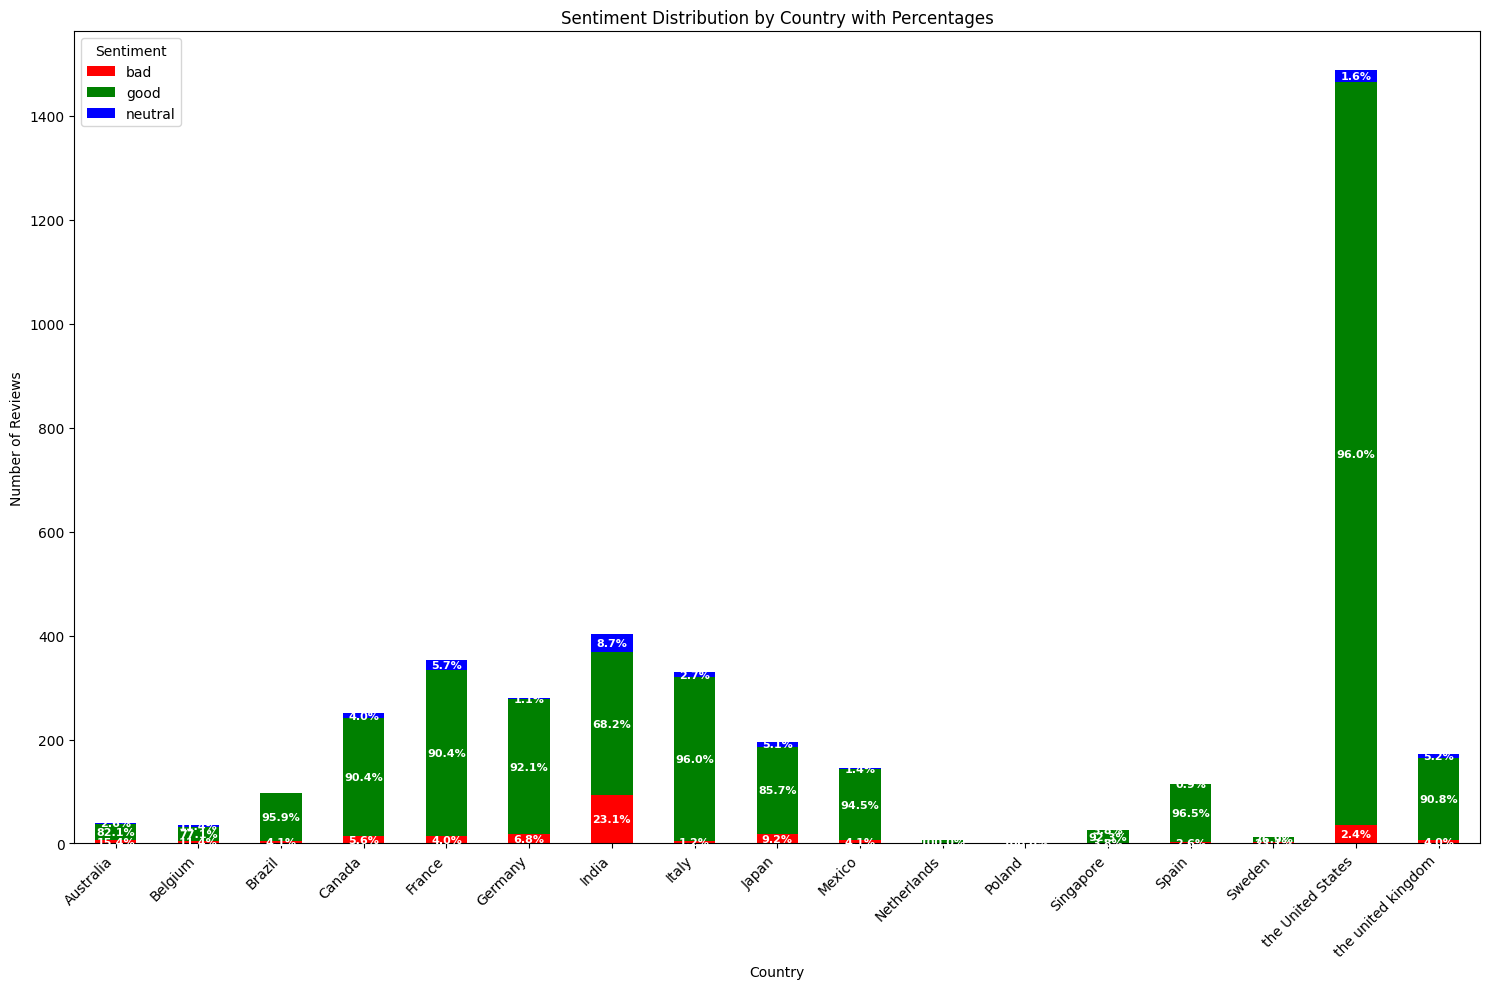

In [85]:
# Group by Country and Sentiment, then count the occurrences
sentiment_counts = review_df.groupby(['Country', 'Sentiment']).size().unstack(fill_value=0)

# Calculate the percentage for each sentiment in each country
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Plotting the data
ax = sentiment_counts.plot(kind='bar', stacked=True, figsize=(15, 10), color=['red', 'green', 'blue'])

# Adding titles and labels
plt.title('Sentiment Distribution by Country with Percentages')
plt.xlabel('Country')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()

# Annotating the bars with percentage values
for i, country in enumerate(sentiment_counts.index):
    for sentiment in sentiment_counts.columns:
        count = sentiment_counts.loc[country, sentiment]
        percentage = sentiment_percentages.loc[country, sentiment]
        if count > 0:
            ax.text(i, sentiment_counts.loc[country, :sentiment].sum() - count / 2,
                    f'{percentage:.1f}%', ha='center', va='center', color='white', fontsize=8, fontweight='bold')

# Show the plot
plt.show()

## Data Preprocessing

#### Lower case of the review so that words are in same case

In [86]:
# Convert the text in the "Review Text" column to lowercase
review_df['Review Text'] = review_df['Review Text'].str.lower()

#### Removing the punctuations

In [87]:
# Convert NaN values to empty strings
review_df['Review Text'] = review_df['Review Text'].fillna('')

# Remove punctuation marks from the "Review Text" column
review_df['Review Text'] = review_df['Review Text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

#### Removing the special characters

In [88]:
# Define a function to remove special characters
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Apply the function to the "Review Text" column
review_df['Review Text'] = review_df['Review Text'].apply(remove_special_characters)

#### Removing the stop words

In [89]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK stop words data
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Define function to remove stop words
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

# Apply the function to the "Review Text" column
review_df['Review Text'] = review_df['Review Text'].apply(remove_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deepe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\deepe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Handling the emojis

In [ ]:
!pip install emoji

#### Tokenizing the reviews text into words

In [90]:
# Define a function to tokenize text
def tokenize_text(text):
    return word_tokenize(text)

# Apply the function to the "Review Text" column
review_df['Tokens'] = review_df['Review Text'].apply(tokenize_text)

# Print the DataFrame with tokenized text
print(review_df[['Review Text', 'Tokens']])

                                            Review Text  \
0     good processor gives able play games office wo...   
1     criticized almost 13600k price also almost thi...   
2     tried limiting power 160w using cooler masters...   
3     product safe good condition really appreciate ...   
4     processor great arrived sealed good condition ...   
...                                                 ...   
3946  factory sealed looks good open box bam youre h...   
3947  motherboard compatible cpu 690 get jump hoops ...   
3948  powered new machine checking several ways conc...   
3949  thinking returning honest runs hot extremely h...   
3950  performance worse 12900k despite running highe...   

                                                 Tokens  
0     [good, processor, gives, able, play, games, of...  
1     [criticized, almost, 13600k, price, also, almo...  
2     [tried, limiting, power, 160w, using, cooler, ...  
3     [product, safe, good, condition, really, appre...  
4

In [91]:
review_df.head()

,Product Name,Review Text,Review Rating,Country,date,year,Tokens,YearMonth,Sentiment,Product Name Encoded,Country Encoded
0,Intel Core i5-14600K Processor,good processor gives able play games office wo...,5,Spain,2024-05-16,2024,"[good, processor, gives, able, play, games, of...",2024-05,good,19,13
1,Intel Core i5-14600K Processor,criticized almost 13600k price also almost thi...,4,Japan,2024-03-13,2024,"[criticized, almost, 13600k, price, also, almo...",2024-03,good,19,8
2,Intel Core i5-14600K Processor,tried limiting power 160w using cooler masters...,3,Japan,2024-03-20,2024,"[tried, limiting, power, 160w, using, cooler, ...",2024-03,neutral,19,8
3,Intel Core i5-14600K Processor,product safe good condition really appreciate ...,5,Mexico,2024-03-23,2024,"[product, safe, good, condition, really, appre...",2024-03,good,19,9
4,Intel Core i5-14600K Processor,processor great arrived sealed good condition ...,4,the United States,2024-05-05,2024,"[processor, great, arrived, sealed, good, cond...",2024-05,good,19,15


### Text vectorization --> Bag of Words ( BoW )

In [92]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the 'Review Text' column
bow_matrix = vectorizer.fit_transform(review_df['Review Text'])

# Convert to DataFrame for better readability
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display the BoW DataFrame
print(bow_df.head())

   002v  00500v  005v  0080  0085v  00xx2xxxx031299xx60xxx5x  01  010  011  \
0     0       0     0     0      0                         0   0    0    0   
1     0       0     0     0      0                         0   0    0    0   
2     0       0     0     0      0                         0   0    0    0   
3     0       0     0     0      0                         0   0    0    0   
4     0       0     0     0      0                         0   0    0    0   

   011v  ...  zufrieden  zugeklebt  zum  zusammen  zuverlssig  zuverlssige  \
0     0  ...          0          0    0         0           0            0   
1     0  ...          0          0    0         0           0            0   
2     0  ...          0          0    0         0           0            0   
3     0  ...          0          0    0         0           0            0   
4     0  ...          0          0    0         0           0            0   

   zuzelt  zw  zwave  zwischen  
0       0   0      0         

### TF- IDF Vectorization

In [93]:
import seaborn as sns

# Step 1: Join Tokens to Form Sentences
review_df['Review Text'] = review_df['Tokens'].apply(lambda tokens: ' '.join(tokens))

# Step 2: Compute the TF-IDF Matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(review_df['Review Text'])

# Step 3: Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,002v,00500v,005v,0080,0085v,00xx2xxxx031299xx60xxx5x,01,010,011,011v,...,zufrieden,zugeklebt,zum,zusammen,zuverlssig,zuverlssige,zuzelt,zw,zwave,zwischen
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Lebel the data

In [94]:
# Define a function to label the reviews based on the rating
def label_sentiment(rating):
    if rating >= 4:
        return 'good'
    elif rating == 3:
        return 'neutral'
    else:
        return 'bad'

# Apply the function to create a 'Sentiment' column
review_df['Sentiment'] = review_df['Review Rating'].apply(label_sentiment)

In [95]:
unique_sentiments = review_df['Sentiment'].unique()
unique_sentiments

array(['good', 'neutral', 'bad'], dtype=object)

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to top 5000 features for efficiency

# Fit and transform the 'Review Text' column
X = tfidf_vectorizer.fit_transform(review_df['Review Text'])

# Extract the target variable
y = review_df['Sentiment']

#### Spliting the dataset

In [97]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Creating the train and test file

In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the sizes you want for train and test sets
train_size = 3161
test_size = 791

# Calculate the proportion for test_size
total_size = train_size + test_size
test_size_proportion = test_size / total_size

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(review_df[['Product Name', 'Review Text', 'Review Rating', 'Country', 'date', 'year', 'Tokens', 'YearMonth', 'Sentiment']], 
                                                    review_df['Sentiment'], 
                                                    test_size=test_size_proportion, 
                                                    random_state=42)

# Display the sizes of train and test sets
print(f"Size of X_train: {len(X_train)}, Size of X_test: {len(X_test)}")
print(f"Size of y_train: {len(y_train)}, Size of y_test: {len(y_test)}")

Size of X_train: 3160, Size of X_test: 791
Size of y_train: 3160, Size of y_test: 791


#### Saving the train and test files

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the sizes you want for train and test sets
train_size = 3161
test_size = 791

# Calculate the proportion for test_size
total_size = train_size + test_size
test_size_proportion = test_size / total_size

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(review_df[['Product Name', 'Review Text', 'Review Rating', 'Country', 'date', 'year', 'Tokens', 'YearMonth']], 
review_df['Sentiment'], test_size=test_size_proportion,random_state=42)

# Concatenate X_train and y_train
train_data = pd.concat([X_train, y_train], axis=1)

# Define file paths
train_file = 'train_data.csv'
test_file = 'test_data.csv'

# Save train dataset to CSV
train_data.to_csv(train_file, index=False)

# Save test dataset (without target variable) to CSV
X_test.to_csv(test_file, index=False)

print(f"Train data saved to {train_file}")
print(f"Test data saved to {test_file}")


Train data saved to train_data.csv
Test data saved to test_data.csv


### Features offered

In [ ]:
import pandas as pd
from collections import Counter

# Print column names to verify the presence of 'Sentiment' column
print("Columns in DataFrame:", review_df.columns)

# Remove any leading or trailing spaces from column names
review_df.columns = review_df.columns.str.strip()

# Print column names again to confirm
print("Columns in DataFrame after stripping spaces:", review_df.columns)

# Filter for positive sentiments
if 'Sentiment' in review_df.columns:
    positive_reviews = review_df[review_df['Sentiment'] == 'good']

    # Ensure 'Tokens' column is properly evaluated as a list
    positive_reviews['Tokens'] = positive_reviews['Tokens'].apply(eval)

    # Extract and aggregate features from tokens
    all_tokens = [token for tokens_list in positive_reviews['Tokens'] for token in tokens_list]
    token_counter = Counter(all_tokens)

    # Display the most common features
    common_features = token_counter.most_common()
    print("Most Common Features in Positive Reviews:")
    for feature, freq in common_features:
        print(f"{feature}: {freq}")

    # Optional: Convert to DataFrame for better visualization
    features_df = pd.DataFrame(common_features, columns=['Feature', 'Frequency'])
    print(features_df.head(10))  # Display top 10 features
else:
    print("Sentiment column is not found in the DataFrame.")

## Now train the model

# ----------------------------------------------------------------------

#### Train the model

In [130]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

#### Evaluate the model

In [131]:
from sklearn.metrics import classification_report, accuracy_score

# Predict the sentiments on the test set
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the accuracy score
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       748
           1       0.96      0.97      0.96       694
           2       0.98      0.97      0.98       712

    accuracy                           0.98      2154
   macro avg       0.98      0.98      0.98      2154
weighted avg       0.98      0.98      0.98      2154

Accuracy: 0.9772516248839369


#### ........................................... 1st Retraining the model....................Working almost perfectly,............................

In [140]:
# Separate majority and minority classes
df_good = review_df[review_df['Sentiment'] == 'good']
df_bad = review_df[review_df['Sentiment'] == 'bad']
df_neutral = review_df[review_df['Sentiment'] == 'neutral']

# Upsample minority classes
df_bad_upsampled = resample(df_bad, 
                            replace=True,     # sample with replacement
                            n_samples=len(df_good),    # to match majority class
                            random_state=123) # reproducible results

df_neutral_upsampled = resample(df_neutral, 
                                replace=True,     # sample with replacement
                                n_samples=len(df_good),    # to match majority class
                                random_state=123) # reproducible results

# Combine majority class with upsampled minority classes
review_df_balanced = pd.concat([df_good, df_bad_upsampled, df_neutral_upsampled])

# Display new class counts
print(review_df_balanced['Sentiment'].value_counts())


Sentiment
good       3590
bad        3590
neutral    3590
Name: count, dtype: int64


In [141]:
# Refit the TF-IDF vectorizer on the balanced dataset
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(review_df_balanced['Review Text'])

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(review_df_balanced['Sentiment'])

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Print the accuracy score
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

              precision    recall  f1-score   support

         bad       0.99      0.99      0.99       748
        good       0.96      0.97      0.96       694
     neutral       0.98      0.97      0.98       712

    accuracy                           0.98      2154
   macro avg       0.98      0.98      0.98      2154
weighted avg       0.98      0.98      0.98      2154

Accuracy: 0.9772516248839369


In [137]:
# Example review
new_review = ["strong"]

# Transform the new review using the same TF-IDF vectorizer
new_review_tfidf = tfidf_vectorizer.transform(new_review)

# Predict the sentiment
predicted_sentiment = model.predict(new_review_tfidf)

# Decode the predicted sentiment
predicted_sentiment_label = le.inverse_transform(predicted_sentiment)

print(f'The sentiment of the new review is: {predicted_sentiment_label[0]}')

The sentiment of the new review is: good


#### ..................................................................2nd Retraining of the model................................Working somewhere correctly

In [142]:
import pandas as pd

# Check class distribution
print(review_df['Sentiment'].value_counts())


Sentiment
good       3590
bad         232
neutral     129
Name: count, dtype: int64


#### Rebalancing the dataset 

In [143]:
from sklearn.utils import resample

# Separate classes
df_good = review_df[review_df.Sentiment == 'good']
df_bad = review_df[review_df.Sentiment == 'bad']
df_neutral = review_df[review_df.Sentiment == 'neutral']

# Determine the maximum class size
max_size = max(len(df_good), len(df_bad), len(df_neutral))

# Upsample classes to balance
df_good_upsampled = resample(df_good, replace=True, n_samples=max_size, random_state=123)
df_bad_upsampled = resample(df_bad, replace=True, n_samples=max_size, random_state=123)
df_neutral_upsampled = resample(df_neutral, replace=True, n_samples=max_size, random_state=123)

# Combine the upsampled classes
df_balanced = pd.concat([df_good_upsampled, df_bad_upsampled, df_neutral_upsampled])

# Display new class distribution
print(df_balanced['Sentiment'].value_counts())


Sentiment
good       3590
bad        3590
neutral    3590
Name: count, dtype: int64


#### retraining the model

In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(review_df_balanced['Review Text'])

# Label Encoding
le = LabelEncoder()
y = le.fit_transform(review_df_balanced['Sentiment'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Print the accuracy score
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

              precision    recall  f1-score   support

         bad       0.99      0.99      0.99       748
        good       0.96      0.97      0.96       694
     neutral       0.98      0.97      0.98       712

    accuracy                           0.98      2154
   macro avg       0.98      0.98      0.98      2154
weighted avg       0.98      0.98      0.98      2154

Accuracy: 0.9772516248839369


In [150]:
# Example review
new_review = ["less heating"]

# Transform the new review using the same TF-IDF vectorizer
new_review_tfidf = tfidf_vectorizer.transform(new_review)

# Predict the sentiment
predicted_sentiment = model.predict(new_review_tfidf)

# Decode the predicted sentiment
predicted_sentiment_label = le.inverse_transform(predicted_sentiment)

print(f'The sentiment of the new review is: {predicted_sentiment_label[0]}')

The sentiment of the new review is: neutral


#### Ensure the proper evaluation

In [151]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
print(f'Cross-validated F1 scores: {cv_scores}')
print(f'Average F1 score: {cv_scores.mean()}')

Cross-validated F1 scores: [0.97351138 0.98515601 0.9753933  0.97770982 0.97017914]
Average F1 score: 0.9763899296949354


## Final accuracy of the model is Accuracy: 0.9772516248839369